In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [26]:
LABEL_PATH = "datasets/data3/data3_Class_Labels.txt"
SM_PATH = "datasets/data3/data3_SM.txt"

In [27]:
def read_data(sm_path, label_path):
    with open(sm_path) as f:
        similarity_data = f.read().splitlines()
    similarity_data = np.array([np.array(one_data.split(','), dtype=float) for one_data in similarity_data])
    similarity_data[np.tril_indices(similarity_data.shape[0], -1)] = np.nan

    with open(label_path) as f:
        label_data = f.read().splitlines()
    label_data = np.array(label_data, dtype=float)
    
    return similarity_data, label_data

def calculate_min_max(similarity_data):
    return np.nanmin(similarity_data), np.nanmax(similarity_data)

def get_genuine_and_imposter_indices(label_data, similarity_data):
    genuine_indices = []
    imposter_indices = []
    for i, elem1 in enumerate(label_data):
        for j, elem2 in enumerate(label_data):
            if not np.isnan(similarity_data[i, j]):
                if elem1 == elem2:
                    genuine_indices.append((i, j))
                else:
                    imposter_indices.append((i, j))
    return genuine_indices, imposter_indices

def get_accepts(t, similarity_data, label_data):
    x, y = np.where(similarity_data > t)
    accept_mask = label_data[x] == label_data[y]
    stacked = np.stack([x,y])
    true_accept = stacked[:,accept_mask]
    false_accept = stacked[:,~accept_mask]
    return true_accept, false_accept
    
def get_rejects(t, similarity_data, label_data):
    x, y = np.where(similarity_data <= t)
    reject_mask = label_data[x] != label_data[y]
    stacked = np.stack([x,y])
    true_reject = stacked[:,reject_mask]
    false_reject = stacked[:,~reject_mask]
    return true_reject, false_reject

def get_far_frr_threshold_vals(error_rate, genuine_indices, imposter_indices):
    eer_vals = []
    for elem in error_rate:
        t, ta, fa, tr, fr = elem[0], elem[1], elem[2], elem[3], elem[4]
        FRR = fr / len(genuine_indices)
        FAR = fa / len(imposter_indices)
        eer_vals.append((t, FRR, FAR))
    t_, frr_, far_  = zip(*eer_vals)
    return np.array(t_), np.array(frr_), np.array(far_)

def get_error_numbers(min_val, max_val, similarity_data, label_data, num_interval):
    error_num = []
    space = np.linspace(min_val, max_val, num=num_interval)

    for t in tqdm(space):
        true_accept, false_accept = get_accepts(t, similarity_data, label_data)
        true_reject, false_reject = get_rejects(t, similarity_data, label_data)
        error_num.append((t, true_accept.shape[1], false_accept.shape[1], true_reject.shape[1], false_reject.shape[1]))

    return np.array(error_num)

def get_eer_val(frr, far):
    ind = np.argmin(np.abs(frr - far))
    return np.mean([frr[ind], far[ind]])

def find_nearest(array, value):
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def plot_far_vs_frr(frr, far):
    plt.figure(figsize=(20,14))
    plt.plot(frr, 'r-', far, 'b-')
    plt.legend(["frr", "far"])
    plt.show()
    
def plot_roc_curve(frr, far):
    plt.figure(figsize=(20,14))
    plt.plot(frr, 1 - np.array(far))
    plt.show()
    
def plot_genuine_imposter_dists(similarity_data, genuine_indices, imposter_indices, min_val, max_val, n_bins):
    plt.figure(figsize=(20,14))
    bins = np.linspace(min_val, max_val, n_bins)
    plt.hist(similarity_data[tuple(zip(*genuine_indices))], bins=bins, label="genuine", alpha=0.5)
    plt.hist(similarity_data[tuple(zip(*imposter_indices))], bins=bins, label="imposter", alpha=0.5)
    plt.legend(loc='upper right')
    plt.show()

In [28]:
similarity_data, label_data = read_data(SM_PATH, LABEL_PATH)
min_val, max_val = calculate_min_max(similarity_data)
genuine_indices, imposter_indices = get_genuine_and_imposter_indices(label_data, similarity_data)

In [29]:
error_num = get_error_numbers(min_val, max_val, similarity_data, label_data, num_interval=100)

100%|██████████| 100/100 [00:02<00:00, 42.54it/s]


In [30]:
t, frr, far = get_far_frr_threshold_vals(error_num, genuine_indices, imposter_indices)
eer = get_eer_val(frr, far)
print("EER value is", eer)

EER value is 0.11665151515151514


In [31]:
frr[find_nearest(far, 0.1)[1]], frr[find_nearest(far, 0.01)[1]], frr[find_nearest(far, 0.001)[1]]

(0.14133333333333334, 0.686, 0.9464444444444444)

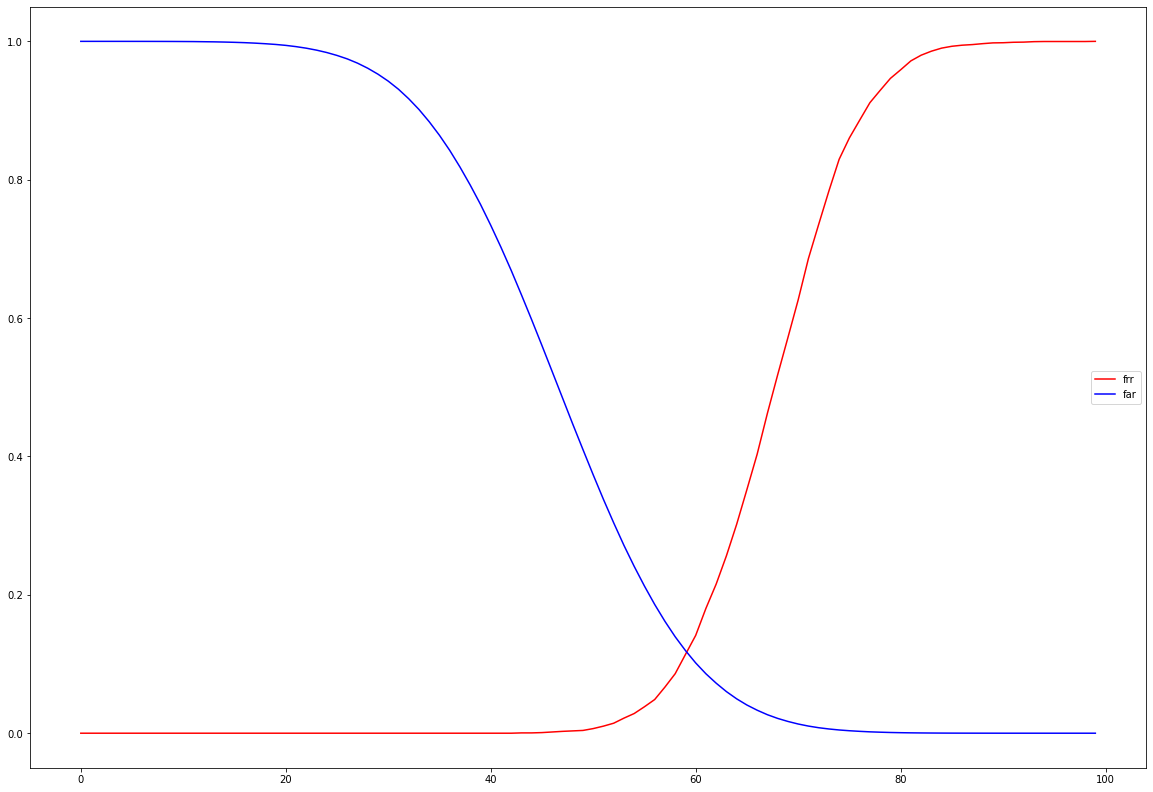

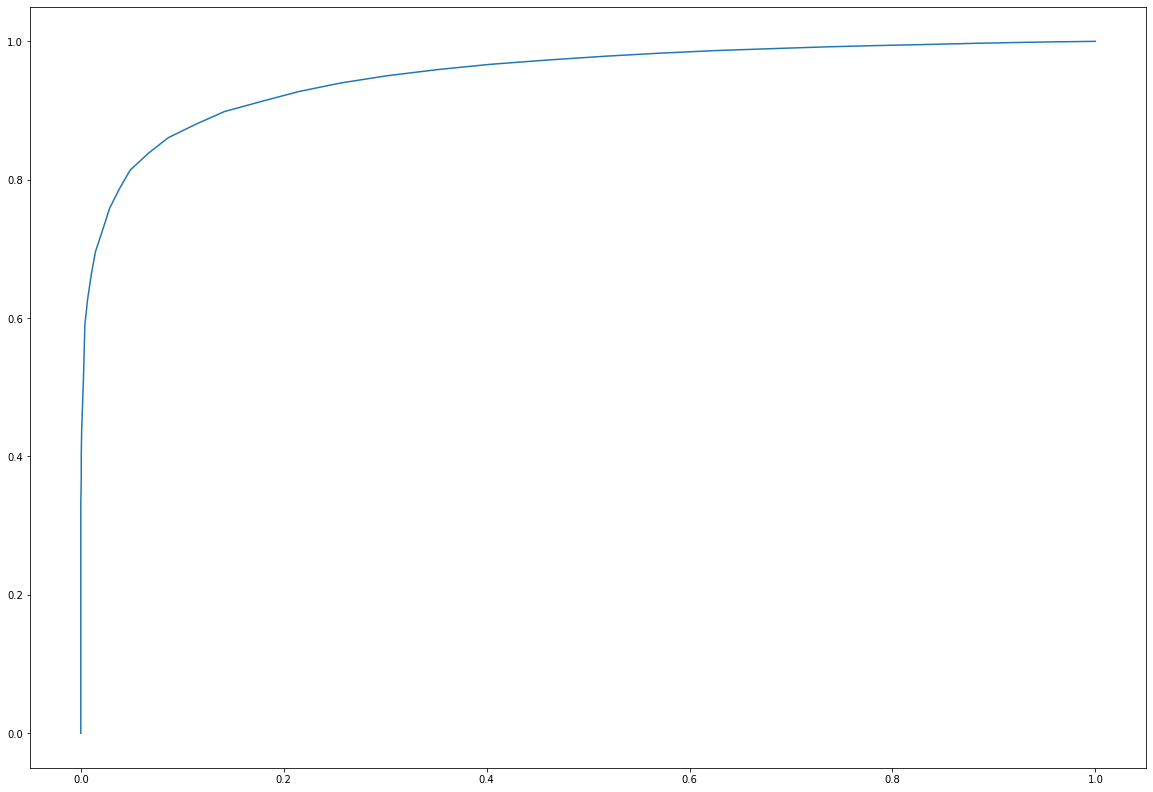

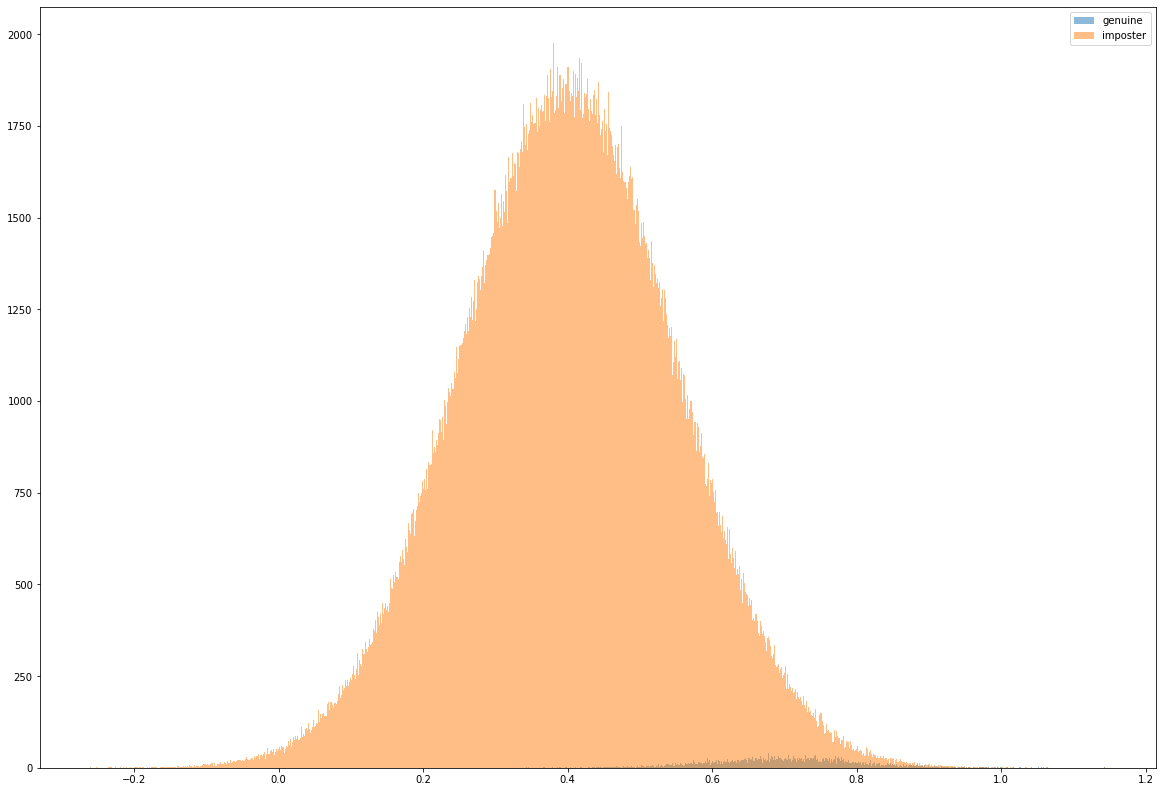

In [32]:
plot_far_vs_frr(frr, far)
plot_roc_curve(frr, far)
plot_genuine_imposter_dists(similarity_data, genuine_indices, imposter_indices, min_val, max_val, n_bins=1000)